In [6]:
%load_ext autoreload
%autoreload 2
import sys
import os
import copy
import itertools
import torch
import numpy as np
import abstract_gradient_training as agt
sys.path.append("..")
from models.fully_connected import FullyConnected
from datasets.uci import get_dataloaders

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [7]:
# configure the training parameters
batchsize = 10000
nominal_config = agt.AGTConfig(
    fragsize=10000,
    learning_rate=0.05,
    lr_decay=1.0,
    lr_min=0.001,
    # epsilon=0.01,
    k_poison=1000,
    clip_gamma=0.05,
    n_epochs=1,
    device="cuda:1",
    forward_bound="interval",
    backward_bound="interval",
    loss="mse",
    log_level="INFO",
    early_stopping=False,
    metadata=f"uci, batchsize={batchsize}",
    bound_kwargs={"interval_matmul": "rump"}
)

In [8]:
# get the data and nn model
torch.manual_seed(0)

dl_train, dl_test = get_dataloaders(batchsize, batchsize, "houseelectric", n_batches=100)
test_batch, test_label = next(iter(dl_test))
dl_test = itertools.cycle([(test_batch[0].unsqueeze(0).repeat(2, 1, 1), test_label[0].unsqueeze(0).repeat(2, 1, 1))])
# dl_test = itertools.cycle([next(iter(dl_test))])
model = FullyConnected(11, 1, 50, 1)  # network with 1 hidden layer of 64 neurons

houseelectric dataset, N=2049280, d=11


In [9]:
conf = copy.deepcopy(nominal_config)
conf.k_private = conf.k_poison
agt_training = []
def log(*args):
    agt_training.append(copy.deepcopy(args))
conf.callback = log

# train the model
# param_l, param_n, param_u = agt.poison_certified_training(model, conf, dl_train, dl_test)
param_l, param_n, param_u = agt.privacy_certified_training(model, conf, dl_train, dl_test)

# evaluate the trained model
mse = agt.test_metrics.test_mse(param_l, param_n, param_u, *next(iter(dl_test)))
print(f"Test MSE: nominal = {mse[1]:.4g}, certified upper bound = {mse[0]:.4g}, certified lower bound = {mse[2]:.4g}")

[AGT] [INFO    ] [18:50:32] =================== Starting Privacy Certified Training ===================
[AGT] [INFO    ] [18:50:33] Starting epoch 1
[AGT] [INFO    ] [18:50:34] Training batch 1: Network eval bounds=(0.067, 0.067, 0.067), W0 Bound=0.0 
[AGT] [INFO    ] [18:50:34] Training batch 2: Network eval bounds=(0.059, 0.055, 0.054), W0 Bound=0.0147 
[AGT] [INFO    ] [18:50:34] Training batch 3: Network eval bounds=(0.055, 0.05, 0.048), W0 Bound=0.0221 
[AGT] [INFO    ] [18:50:34] Training batch 4: Network eval bounds=(0.053, 0.047, 0.044), W0 Bound=0.0272 
[AGT] [INFO    ] [18:50:34] Training batch 5: Network eval bounds=(0.051, 0.044, 0.041), W0 Bound=0.031 
[AGT] [INFO    ] [18:50:35] Training batch 6: Network eval bounds=(0.05, 0.042, 0.039), W0 Bound=0.0341 
[AGT] [INFO    ] [18:50:35] Training batch 7: Network eval bounds=(0.049, 0.041, 0.037), W0 Bound=0.0367 
[AGT] [INFO    ] [18:50:35] Training batch 8: Network eval bounds=(0.048, 0.04, 0.036), W0 Bound=0.0389 
[AGT] [INF

Test MSE: nominal = 0.01977, certified upper bound = 0.03458, certified lower bound = 0.01268


In [10]:
def train_poison(model, config, type, r, n_poison):
    poison_model = copy.deepcopy(model)

    poison_params, _, _ = agt.training_utils.get_parameters(poison_model)
    poison_param_list = []
    criterion = torch.nn.MSELoss()
    
    poison_training = []
    test_iterator = itertools.cycle(dl_test)
    lrk = 0
    for _ in range(config.n_epochs):
        for x, y in dl_train:
            poison_param_list.append([p.clone().detach() for p in poison_params])
            lr = max(config.learning_rate / (1 + config.lr_decay * lrk), config.lr_min)
            lrk += 1
            test_batch, test_labels = next(test_iterator)
            test_batch, test_labels = test_batch.to(config.device), test_labels.to(config.device)
            *_, y_test = agt.nominal_pass.nominal_forward_pass(test_batch, poison_params)
            poison_training.append(criterion(y_test, test_labels).item())
            if x.size(0) != batchsize:
                continue
            # print(f"Test MSE: {standard_training[-1]:.4g}")
            x, y = x.to(config.device), y.to(config.device)
            # poison config.k_poison examples
            selected = torch.randperm(x.size(0))[:n_poison]
            poison_x = torch.tile(test_batch[0], (n_poison, 1, 1))
            if type == 1:
                poison_y = torch.randn(n_poison, 1, 1, device=config.device) * 100 * r
            elif type == 2:
                poison_y = torch.tile(test_labels[0], (n_poison, 1, 1))
            elif type == 3:
                poison_y = torch.ones(n_poison, 1, 1, device=config.device) * r
            with torch.no_grad():
                x[selected] = poison_x
                y[selected] = poison_y
                activations_n = agt.nominal_pass.nominal_forward_pass(x, poison_params)
                _, _, dl_n = config.loss_bound_fn(activations_n[-1], activations_n[-1], activations_n[-1], y)
                grads_n = agt.nominal_pass.nominal_backward_pass(dl_n, param_n, activations_n)
                grads_n = [g.clamp(-config.clip_gamma, config.clip_gamma) for g in grads_n]
                grads_n = [g.mean(dim=0) for g in grads_n]
                for p, g in zip(poison_params, grads_n):
                    p -= lr * g
    return poison_training, poison_param_list

In [11]:
trajectories = []
for i in range(3):
    poison_training, _ = train_poison(model, conf, type=1, r=i)
    trajectories.append(poison_training)
    poison_training, _ = train_poison(model, conf, type=2, r=i)
    trajectories.append(poison_training)
    poison_training, _ = train_poison(model, conf, type=3, r=i)
    trajectories.append(poison_training)

/tmp/ipykernel_2862185/182738915.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


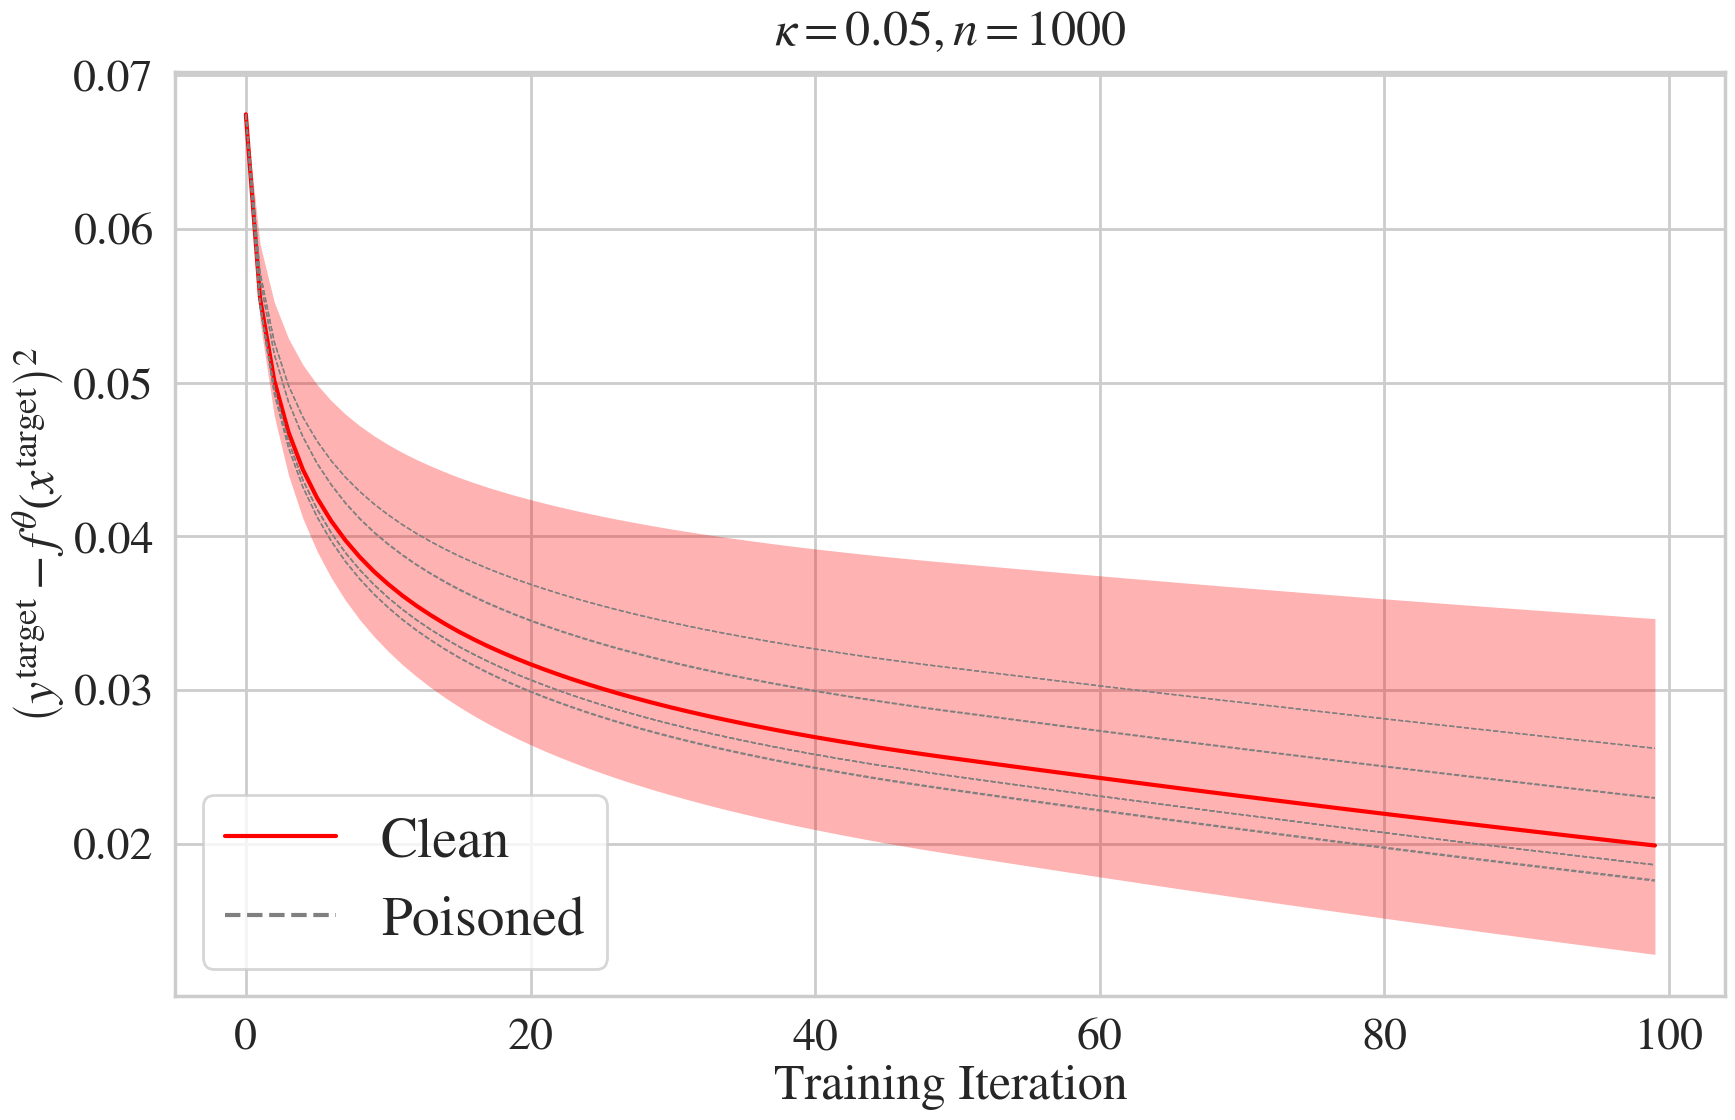

In [12]:
palette = sns.color_palette(palette="Dark2", n_colors=12)
lb_color = list(iter(sns.color_palette(palette="deep")))[-1]
ub_color = list(iter(sns.color_palette(palette="deep")))[-2]

sns.set_theme(context="poster", style="whitegrid", font_scale=1.5)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
labelsize = 22

mse_u = [t[0][0] for t in agt_training]
mse_n = [t[0][1] for t in agt_training]
mse_l = [t[0][2] for t in agt_training]


fig, ax = plt.subplots(1, 1, figsize=(20, 12))

ax.fill_between(range(len(mse_n)), mse_l, mse_u, color="red", alpha=0.3, lw=0)

plt.plot(mse_n, color="red")
# plt.plot(mse_l, label="Lower bound")
# plt.plot(mse_u, label="Upper bound")
plt.xlabel("Training Iteration")
plt.ylabel(r"$\left(y^{\text{target}} - f^\theta(x^{\text{target}}\right)^2$")
plt.legend()
ax.set_title(f"$\kappa={nominal_config.clip_gamma}, n={nominal_config.k_poison}$", pad=20)

ax.plot([], [], color="red", label="Clean")
ax.plot([], [], color="grey", label="Poisoned", linestyle="--")
ax.legend(loc="lower left", fontsize=40)

for t in trajectories:
    plt.plot(t, color="grey", linestyle="--", linewidth=1)

# plt.ylim(agt_training[-1][0][2], agt_training[-1][0][0] + 0.005)